<a href="https://colab.research.google.com/github/GergelyTuri/sleep/blob/master/notebooks/attractor/Single_session_DCA_analysis_intervals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prototype notebook for toying with attractor models

based on Zhenrui's notebook.

* 3/13/2024 setup
* 3/14/2024 adding more efficient data loading, interactive plot and refined animation code (it is still slow tho)
* 3/20/2024 calculations with intervals
* 3/23/2024 format to single session. Also, interval calculation is fixed, so the ovelap filter has been removed

In [ ]:
!git clone https://github.com/GergelyTuri/sleep.git

In [ ]:
%cd sleep
!pip install .

In [ ]:
# %cd sleep
# !git pull

In [ ]:
!pip install git+https://github.com/BouchardLab/DynamicalComponentsAnalysis.git
!pip install -U kaleido # required for saving plotly figs as static images (png)

In [4]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [1]:
from os.path import join
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegWriter
import numpy as np
import pandas as pd

import seaborn as sns
sns.set(context="talk", style="ticks")
import sklearn
import os
from os.path import join
import scipy

from sleep.src import google_drive, clustering

# DCA
from dca import DynamicalComponentsAnalysis as DCA, style
from dca.cov_util import calc_cross_cov_mats_from_data
from dca.synth_data import embedded_lorenz_cross_cov_mats, gen_lorenz_data, random_basis, median_subspace
from dca.plotting.fig1 import lorenz_fig_axes, plot_3d, plot_lorenz_3d, plot_traces, plot_dca_demo, plot_r2, plot_cov

import plotly.graph_objects as go
import plotly.io as pio
from plotly.subplots import make_subplots

In [ ]:
useful_data = google_drive.useful_datasets()
useful_data

In [3]:
 in_row = 6
 exp_path = google_drive.return_exp_path(useful_data.iloc[in_row]['mouseID'],
                                            useful_data.iloc[in_row]['day'],
                                            useful_data.iloc[in_row]['sessionID'])

### Data wrangling

In [ ]:
# data
velo_eeg = pd.read_csv(join(exp_path, 'eeg', "velo_eeg.csv"))
dfof = pd.read_csv(join(exp_path, "dfof.csv"))
dfof = dfof.set_index("roi_label")

awake_ints = clustering.interval_length_calculator(velo_eeg, 'awake', 1)
nrem_ints = clustering.interval_length_calculator(velo_eeg, 'NREM', 1)

# Filter intervals based on a given lenght
del_indices = nrem_ints.loc[nrem_ints["length"] < 1200, "n"].values
summary_nrem = nrem_ints[~nrem_ints["n"].isin(del_indices)].reset_index(drop=True).copy()

del_indices = awake_ints.loc[awake_ints["length"] < 1200, "n"].values
summary_awake = awake_ints[~awake_ints["n"].isin(del_indices)].reset_index(drop=True).copy()

awake_dfof = clustering.process_dfof_intervals(dfof, summary_awake)
nrem_dfof = clustering.process_dfof_intervals(dfof, summary_nrem)

# Now join the DataFrames and sort
merged_df = awake_dfof.join(nrem_dfof)

merged_df.columns = merged_df.columns.astype(int)
merged_df = merged_df.sort_index(axis=1)

merged_columns = merged_df.columns.astype(int)
columns_list = merged_columns.tolist()

velo_eeg.index = velo_eeg.index.astype(int)
filtered_velo_eeg = velo_eeg.loc[velo_eeg.index.intersection(columns_list)]

### Calculations for DCA:

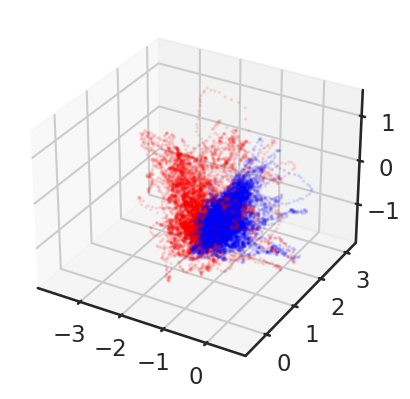

In [4]:
# input data for DCA
dfof = merged_df
velo_eeg = filtered_velo_eeg.reset_index(drop=True)

#Run DCA
opt = DCA(T=10, d=2)
opt.fit(np.asarray(dfof.T))
V_dca = opt.coef_

#Project data onto DCA and PCA bases
X_dca = np.dot(np.asarray(dfof.T), V_dca)

# downsample dfof
X_roll = dfof.T.rolling(10).mean().dropna()

opt_roll = DCA(T=10, d=2)
opt_roll.fit(np.asarray(X_roll))
V_dca = opt_roll.coef_

Xroll_dca = np.dot(np.asarray(X_roll), V_dca)

opt_3 = DCA(T=10, d=3)
opt_3.fit(np.asarray(X_roll))
V_dca3 = opt_3.coef_
X_dca3 = np.dot(np.asarray(X_roll), V_dca3)

### Plotting results:

In [ ]:
# Scatter
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(X_dca3[:, 0], X_dca3[:, 1], X_dca3[:, 2],
        c=velo_eeg['awake'].iloc[9:], cmap='bwr', s=1,alpha=0.1)
# fig.savefig(join(exp_path, 'dca_3d.png'), dpi=300)

#### Interval plots

In [5]:
def plot_intervals(awake_df, nrem_df, target_row, fig):
    """
    Adds interval lines to a specific row of the subplot figure for both awake and NREM intervals.

    Args:
        awake_df (pd.DataFrame): DataFrame containing awake intervals.
        nrem_df (pd.DataFrame): DataFrame containing NREM intervals.
        target_row (int): The row number in the subplot to add the intervals to.
        fig (go.Figure): The figure object to add the intervals to.
    """
    colors = {'awake': 'rgba(0, 0, 255, 0.5)', 'nrem': 'rgba(255, 165, 0, 0.5)'}

    def add_interval_lines(df, y_level, color):
        for _, interval_row in df.iterrows():
            fig.add_trace(go.Scatter(x=[interval_row['start'], interval_row['stop']], y=[y_level, y_level], mode='lines',
                                     line=dict(color=color, width=4)),
                          row=target_row, col=1)

    add_interval_lines(awake_df, 2, colors['awake'])
    add_interval_lines(nrem_df, 1, colors['nrem'])

def create_interval_plots(awake_ints, nrem_ints, summary_awake, summary_nrem, length_threshold):
    # Adjusted subplot_titles here
    fig = make_subplots(rows=2, cols=1, vertical_spacing=0.1,
                        subplot_titles=("All intervals", f"Intervals > {length_threshold} length"))

    plot_intervals(awake_ints, nrem_ints, 1, fig)
    plot_intervals(summary_awake, summary_nrem, 2, fig)

    fig.update_layout(height=600, width=800, title_text="Intervals of Awake and NREM Episodes",
                      yaxis=dict(tickvals=[1, 2], ticktext=["NREM", "Awake"]),
                      yaxis2=dict(tickvals=[1, 2], ticktext=["NREM", "Awake"]),
                      showlegend=False)
    fig.write_html("plot.html")
    fig.write_image("plot.png", width=1600, height=1200, scale=2)  # Adjust width, height, and scale as needed
    fig.show()

# Example usage:
create_interval_plots(awake_ints, nrem_ints, summary_awake, summary_nrem, length_threshold=1200)


#### Interactive cluster plot

In [6]:
# Convert boolean array to numeric values: True to 1, False to 0
color_data_numeric = np.where(velo_eeg['awake'].iloc[9:], 1, 0)

#interactive plot
fig = go.Figure(data=[go.Scatter3d(
    x=X_dca3[:, 0],
    y=X_dca3[:, 1],
    z=X_dca3[:, 2],
    mode='markers',
    marker=dict(
        size=2,
        color=color_data_numeric,  # Numeric values for colorscale
        colorscale='RdBu',  # Choosing a diverging colorscale for binary data
        colorbar=dict(title='Awake State'),
        opacity=0.1
    )
)])

fig.update_layout(scene=dict(
                    xaxis_title='X AXIS TITLE',
                    yaxis_title='Y AXIS TITLE',
                    zaxis_title='Z AXIS TITLE'),
                width=700,
                margin=dict(r=20, b=10, l=10, t=10))
# fig.write_html(join(exp_path, 'interactive_plot.html'))


#### DCA3 projection plots

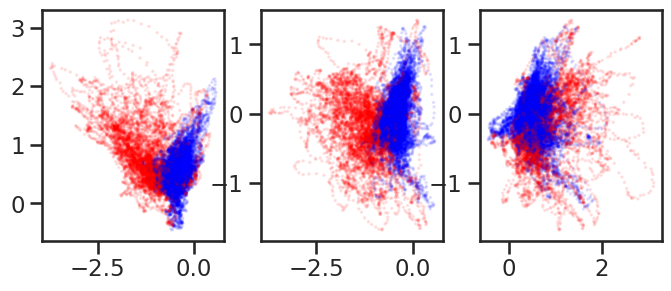

In [7]:
fig, axes = plt.subplots(1,3,figsize=(8,3))
axes[0].scatter(X_dca3[:,0], X_dca3[:,1],c=velo_eeg['awake'][9:],
                cmap='bwr',alpha=0.1,s=1)
axes[1].scatter(X_dca3[:,0], X_dca3[:,2],c=velo_eeg['awake'][9:],
                cmap='bwr',alpha=0.1,s=1)
axes[2].scatter(X_dca3[:,1], X_dca3[:,2],c=velo_eeg['awake'][9:],
                cmap='bwr',alpha=0.1,s=1)
# fig.savefig(join(exp_path, 'dcas.png'), dpi=300)



#### DCA2 dim plot

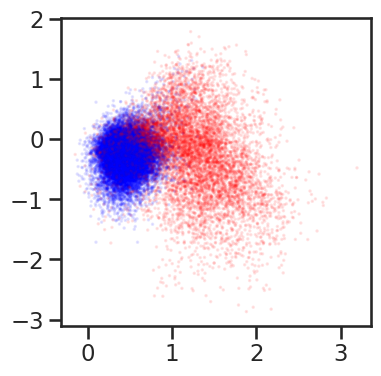

In [8]:
fig, ax = plt.subplots(figsize=(4,4))
ax.scatter(X_dca[:,0], X_dca[:,1],c=velo_eeg['awake'], cmap='bwr',alpha=0.1,s=1)
# fig.savefig(join(exp_path, 'dca_scatter.png'), dpi=300)

#### DCA plot with behavior

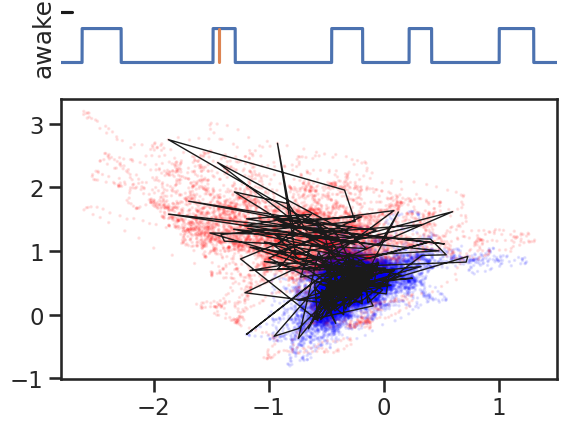

In [10]:
fig, (ax_state, ax_scatter) = plt.subplots(2,1,gridspec_kw={"height_ratios":[1,5]})
ax_state.plot(velo_eeg['awake'].iloc[9:])
sns.despine(ax=ax_state, left=True, bottom=True)
ax_state.set_xlim([9,len(Xroll_dca)])
ax_state.plot([9,9+600],[1.5,1.5],color='k')
ax_state.set_xticks([])
ax_state.set_yticks([])
ax_state.set_ylabel("awake")

line, = ax_state.plot([900, 900], [0,1])
line.set_data([9000, 9000], [0,1])

ax_scatter.scatter(Xroll_dca[:,0], Xroll_dca[:,1],c=velo_eeg['awake'].iloc[9:],
                cmap='bwr',alpha=0.1,s=1)
ax_scatter.plot(Xroll_dca[::100,0], Xroll_dca[::100,1],lw=1, c='k')

# fig.savefig(join(exp_path, 'composit.png'), dpi=300)

## Animation (slow)

In [ ]:
fig, (ax_state, ax_scatter) = plt.subplots(2, 1, gridspec_kw={"height_ratios": [1, 5]})

def init(Xroll_dca, velo_eeg):
    ln_state, = ax_state.plot([9, 9], [0, 1], lw=2)
    ax_state.plot(velo_eeg['awake'].iloc[9:], alpha=0.5)
    sns.despine(ax=ax_state, left=True, bottom=True)
    ax_state.set_xlim([9, len(Xroll_dca)])
    ax_state.plot([9, 9+600], [1.5, 1.5], color='k')
    ax_state.set_xticks([])
    ax_state.set_yticks([])
    ax_state.set_ylabel("awake")

    ax_scatter.scatter(Xroll_dca[:, 0], Xroll_dca[:, 1], c=velo_eeg['awake'].iloc[9:], cmap='bwr', alpha=0.1, s=1)
    ln_scatter, = ax_scatter.plot([], [], 'k-', lw=1)

    return [ln_state, ln_scatter], ax_state, ax_scatter

def update(frame, Xroll_dca, line, xdata, ydata):
    x, y = Xroll_dca[frame]  # frame
    if len(xdata) >= 8:  # Keep the last 8 points only
        xdata.pop(0)
        ydata.pop(0)
    xdata.append(x)
    ydata.append(y)
    line[1].set_data(xdata, ydata)
    line[0].set_data([frame, frame], [0, 1])
    return line

# Initialize the figure
line, ax_state, ax_scatter = init(Xroll_dca, velo_eeg)
xdata, ydata = [], []

# Animation
ani = FuncAnimation(fig, lambda frame: update(frame, Xroll_dca, line, xdata, ydata), frames=np.arange(0, len(Xroll_dca[9:]), 100), init_func=lambda: init(Xroll_dca, velo_eeg)[0], blit=True)

# Saving
writervideo = FFMpegWriter(fps=6)
ani.save(join(exp_path, 'dynamics.mp4'), writer=writervideo)

plt.close()
